In [1]:
import pandas as pd
import sys
sys.path.insert(0, "../..")
from utils.simulation import BacktestSimulation, TradingAction
from utils.black_scholes import black_scholes_call
from datetime import datetime, timedelta

# Configuration
ticker = "MSTR"
strike_factor = 1.10  # 10% OTM for LEAPs
interest_rate = 0.05
leap_duration_days = 365  # LEAPs are typically 1+ year out

tickers = [ticker]
start = datetime(2024, 1, 1)
end = datetime(2024, 12, 31)
initial_cash = 10000

Loading market data...


/Users/ryan/Desktop/quantitative-trading-models/strategies/leap/../../utils/simulation.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=self.start_date, end=self.end_date, progress=False)


Running simulation from 2024-01-02 to 2024-12-30
Total trading days: 251

LEAP STRATEGY PERFORMANCE

=== Performance Summary ===
Initial Value: $10,000.00
Final Value: $122,879.01
Total Return: 1128.79%
Sharpe Ratio: 2.19
Max Drawdown: 95.44%
Annualized Volatility: 1650.30%

Total transactions: 3

Transaction History:
        date      action ticker  contracts      strike  premium_per_share  total_premium expiration
0 2024-01-02    BUY_CALL   MSTR          6   75.366499          16.310529    9786.317279 2025-01-01
1 2024-10-04  CLOSE_CALL   MSTR          6   75.366499         102.314775   61388.864908 2025-01-01
2 2024-10-04    BUY_CALL   MSTR         11  194.160994          53.093125   58402.437883 2025-10-04


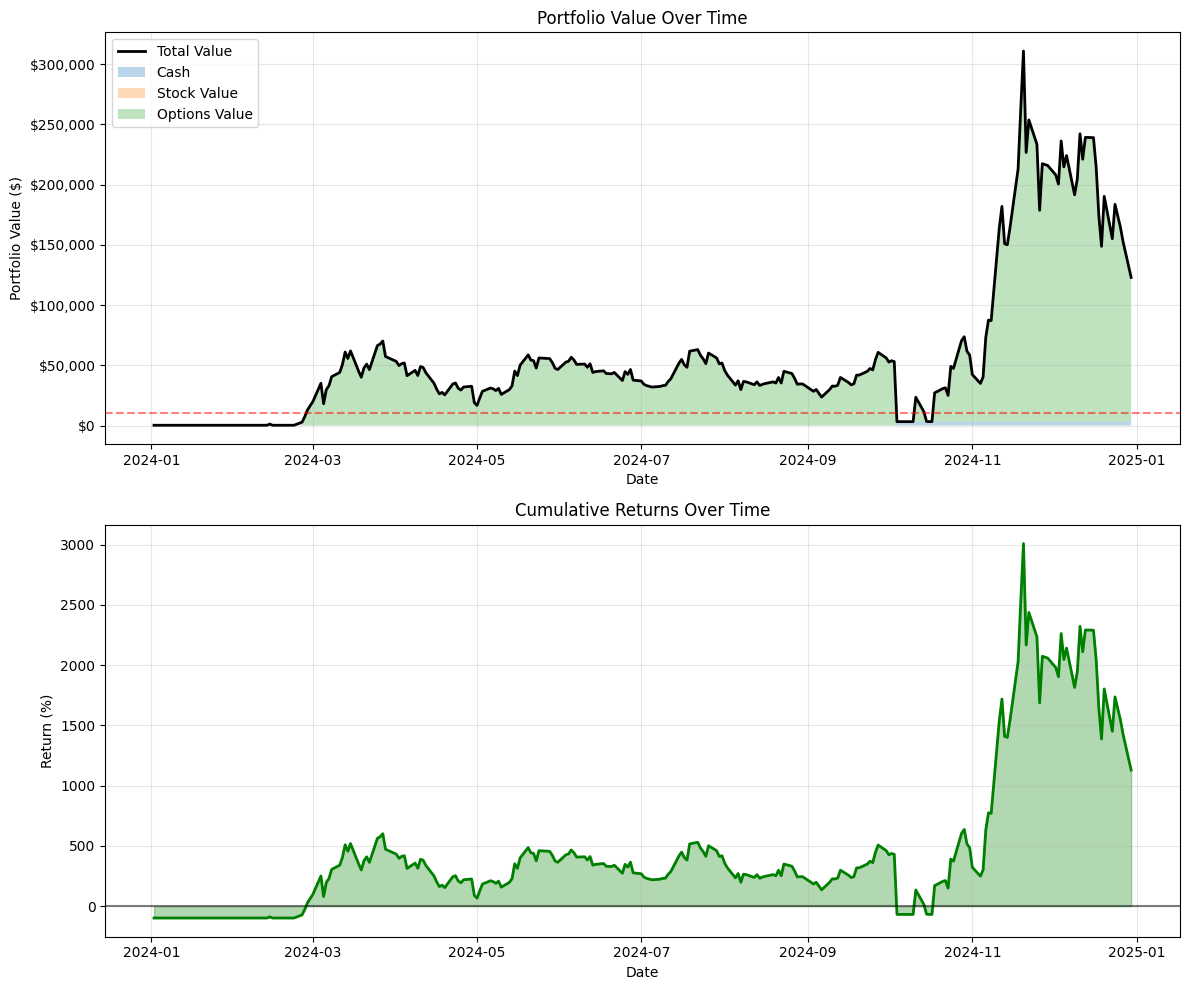

In [2]:
def leap_strategy(date, portfolio, market_data, actions):
    """
    LEAP strategy:
    1. Buy long-dated call options (1 year+ expiration) instead of stock
    2. Use leverage - control more shares with less capital
    3. Roll options forward periodically to maintain exposure
    """
    current_price = market_data['prices'][ticker]
    
    # Check if we have any active LEAP calls
    has_active_leap = any(opt.ticker == ticker and 
                          opt.option_type == 'call' and 
                          opt.position == 'long'
                          for opt in portfolio.options)
    
    # Buy LEAPs if we don't have any and have cash
    if not has_active_leap and portfolio.cash > 1000:
        strike = current_price * strike_factor  # 10% OTM
        expiration = date + timedelta(days=leap_duration_days)
        
        # Get volatility for Black-Scholes
        if ticker in market_data['volatility']:
            vol_data = market_data['volatility'][ticker]
            if len(vol_data) > 0:
                vol = vol_data.iloc[-1, 0] if hasattr(vol_data.iloc[-1], '__iter__') else vol_data.iloc[-1]
                
                if not pd.isna(vol):
                    # Calculate premium using Black-Scholes
                    premium = black_scholes_call(
                        S=current_price,
                        K=strike,
                        sigma=vol,
                        r=interest_rate,
                        t=leap_duration_days/365
                    )
                    
                    # Calculate how many contracts we can afford
                    premium_per_contract = premium * 100
                    max_contracts = int(portfolio.cash / premium_per_contract)
                    
                    if max_contracts > 0:
                        actions.buy_call(
                            portfolio=portfolio,
                            ticker=ticker,
                            strike=strike,
                            expiration=expiration,
                            contracts=max_contracts,
                            premium=premium
                        )
    
    # Check if we need to roll LEAPs (when they get close to expiration)
    # Roll if less than 90 days to expiration
    for opt in portfolio.options:
        if (opt.ticker == ticker and 
            opt.option_type == 'call' and 
            opt.position == 'long'):
            days_to_expiration = (opt.expiration_date - date).days
            
            if days_to_expiration < 90 and days_to_expiration > 0:
                # Close the current LEAP
                if ticker in market_data['volatility']:
                    vol_data = market_data['volatility'][ticker]
                    if len(vol_data) > 0:
                        vol = vol_data.iloc[-1, 0] if hasattr(vol_data.iloc[-1], '__iter__') else vol_data.iloc[-1]
                        
                        if not pd.isna(vol):
                            # Calculate current value of the option
                            current_premium = black_scholes_call(
                                S=current_price,
                                K=opt.strike,
                                sigma=vol,
                                r=interest_rate,
                                t=days_to_expiration/365
                            )
                            
                            # Close the old LEAP
                            actions.close_call(
                                portfolio=portfolio,
                                ticker=ticker,
                                strike=opt.strike,
                                expiration=opt.expiration_date,
                                contracts=opt.contracts,
                                premium=current_premium
                            )
                            
                            # Buy new LEAP with the proceeds
                            new_strike = current_price * strike_factor
                            new_expiration = date + timedelta(days=leap_duration_days)
                            
                            new_premium = black_scholes_call(
                                S=current_price,
                                K=new_strike,
                                sigma=vol,
                                r=interest_rate,
                                t=leap_duration_days/365
                            )
                            
                            new_premium_per_contract = new_premium * 100
                            max_new_contracts = int(portfolio.cash / new_premium_per_contract)
                            
                            if max_new_contracts > 0:
                                actions.buy_call(
                                    portfolio=portfolio,
                                    ticker=ticker,
                                    strike=new_strike,
                                    expiration=new_expiration,
                                    contracts=max_new_contracts,
                                    premium=new_premium
                                )
                            break  # Only roll one position at a time

# Run LEAP strategy simulation
sim_leap = BacktestSimulation(
    tickers=tickers,
    start_date=start,
    end_date=end,
    initial_cash=initial_cash,
    strategy_callback=leap_strategy
)

results_leap = sim_leap.run()

print("\n" + "="*50)
print("LEAP STRATEGY PERFORMANCE")
print("="*50)
sim_leap.print_performance_stats()

transactions_leap = sim_leap.get_transactions()
print(f"\nTotal transactions: {len(transactions_leap)}")
print("\nTransaction History:")
print(transactions_leap.to_string())

sim_leap.plot_portfolio_history()

Loading market data...
Running simulation from 2024-01-02 to 2024-12-30
Total trading days: 251

BUY AND HOLD STRATEGY PERFORMANCE

=== Performance Summary ===
Initial Value: $10,000.00
Final Value: $43,994.52
Total Return: 339.95%
Sharpe Ratio: 1.90
Max Drawdown: 46.31%
Annualized Volatility: 109.96%

Total transactions: 1


/Users/ryan/Desktop/quantitative-trading-models/strategies/leap/../../utils/simulation.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=self.start_date, end=self.end_date, progress=False)


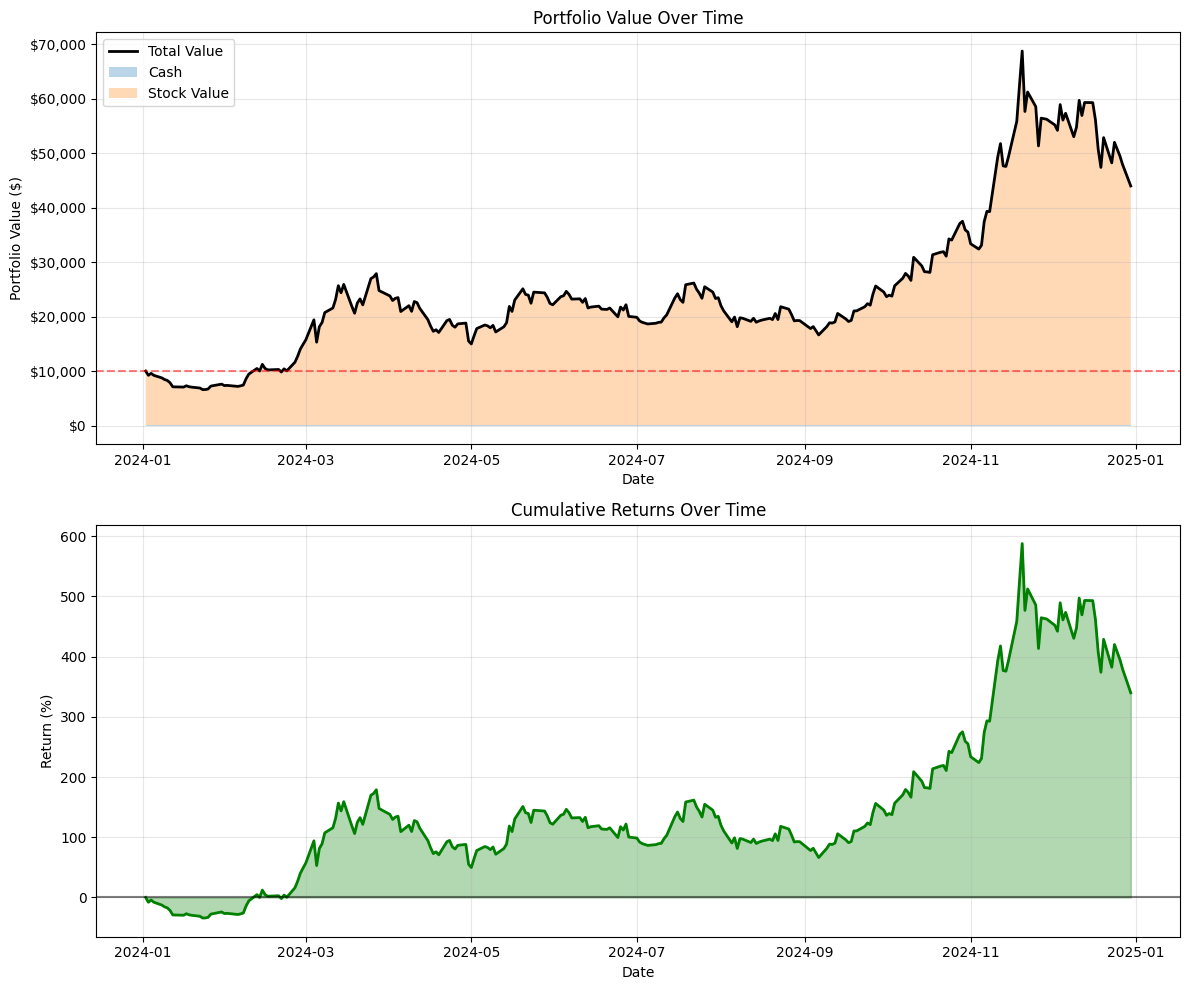

In [3]:
# Compare with Buy and Hold strategy
def buy_and_hold(date, portfolio, market_data, actions):
    """Simple buy and hold strategy for comparison"""
    current_price = market_data['prices'][ticker]
    
    # Buy stock with all available cash on first day
    if ticker not in portfolio.positions or portfolio.positions[ticker].shares == 0:
        max_shares = int(portfolio.cash / current_price)
        if max_shares > 0:
            actions.buy_stock(portfolio, ticker, max_shares, current_price)

# Run buy and hold simulation
sim_bh = BacktestSimulation(
    tickers=tickers,
    start_date=start,
    end_date=end,
    initial_cash=initial_cash,
    strategy_callback=buy_and_hold
)

results_bh = sim_bh.run()

print("\n" + "="*50)
print("BUY AND HOLD STRATEGY PERFORMANCE")
print("="*50)
sim_bh.print_performance_stats()

transactions_bh = sim_bh.get_transactions()
print(f"\nTotal transactions: {len(transactions_bh)}")

sim_bh.plot_portfolio_history()

# LEAP Strategy Analysis

## Strategy Overview
This notebook implements a LEAP (Long-term Equity Anticipation Securities) options strategy:
- **Buy long-dated call options** (1 year expiration) instead of buying stock directly
- **Strike**: 10% OTM (Out of The Money) for cheaper premiums
- **Leverage**: Control more shares with less capital
- **Rolling**: Automatically roll options forward when they have < 90 days to expiration

## Key Advantages
1. **Capital Efficiency**: LEAPs require less upfront capital than buying stock
2. **Leverage**: Control 100 shares per contract with a fraction of the stock cost
3. **Limited Downside**: Maximum loss is limited to the premium paid
4. **Upside Potential**: Participate in most of the stock's upside movement

## Comparison
We compare the LEAP strategy against a simple buy-and-hold strategy using the same initial capital.